# Présentation des données

Dans ce notebook, nous allons commencer par prendre en main les données fournit.

In [ ]:
#!pip3 install missingno

In [1]:
import pandas as pd
import missingno as msno

In [10]:
file_name = "../data/claimKG.csv"

# Lecture du fichier
kg = pd.read_csv(file_name)

In [11]:
origin = kg.copy()

nb_assertion = len(kg)
print("Le nombre d'assertions : ", nb_assertion)

Le nombre d'assertions :  39218


## Données manquantes

On voit bien sur le schéma ci-dessous les données qui manquent:

- ClaimReview_author
- ClaimReview_author_url
- creativeWork_author_name
- creativeWork_author_sameAs
- creativeWork_datePublished 
- rating_bestRating
- rating_ratingValue
- rating_worstRating

Les données manquantes: 


<AxesSubplot:>

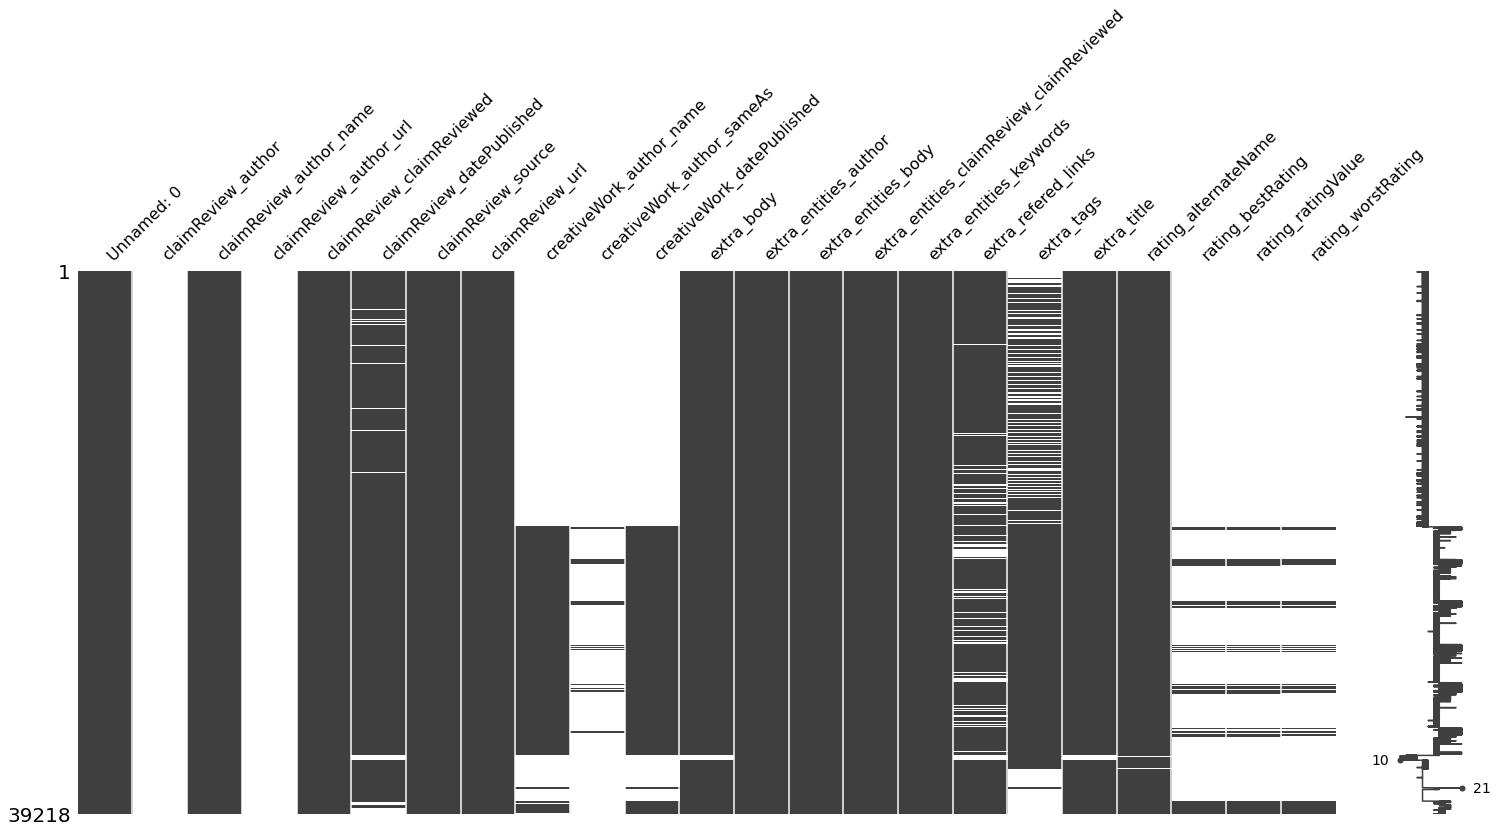

In [12]:
print("Les données manquantes: ")
msno.matrix(origin)

On voit ici que certaines colonnes sont complétement ou majoritairement manquantes.
Il faut donc les supprimer, car ils ne nous servirons pas pour entraîner notre modèle.

In [11]:
manq = origin.isnull().sum()
col_manq = ['Unnamed: 0','claimReview_source']
for k, v in manq.items():
    if v > nb_assertion/2 :
        col_manq.append(k)
        
print("Les colonnes qui seront supprimés: ")
for col in col_manq:
    print("->",col)

Unnamed: 0                                      0
claimReview_author                          39218
claimReview_author_name                         0
claimReview_author_url                      39218
claimReview_claimReviewed                       2
claimReview_datePublished                    1305
claimReview_source                              0
claimReview_url                                 0
creativeWork_author_name                    21737
creativeWork_author_sameAs                  37908
creativeWork_datePublished                  21671
extra_body                                    352
extra_entities_author                           0
extra_entities_body                             0
extra_entities_claimReview_claimReviewed        0
extra_entities_keywords                         0
extra_refered_links                          3825
extra_tags                                   8979
extra_title                                   349
rating_alternateName                          254


Une fois enlever, on obtient le schéma suivant.

<AxesSubplot:>

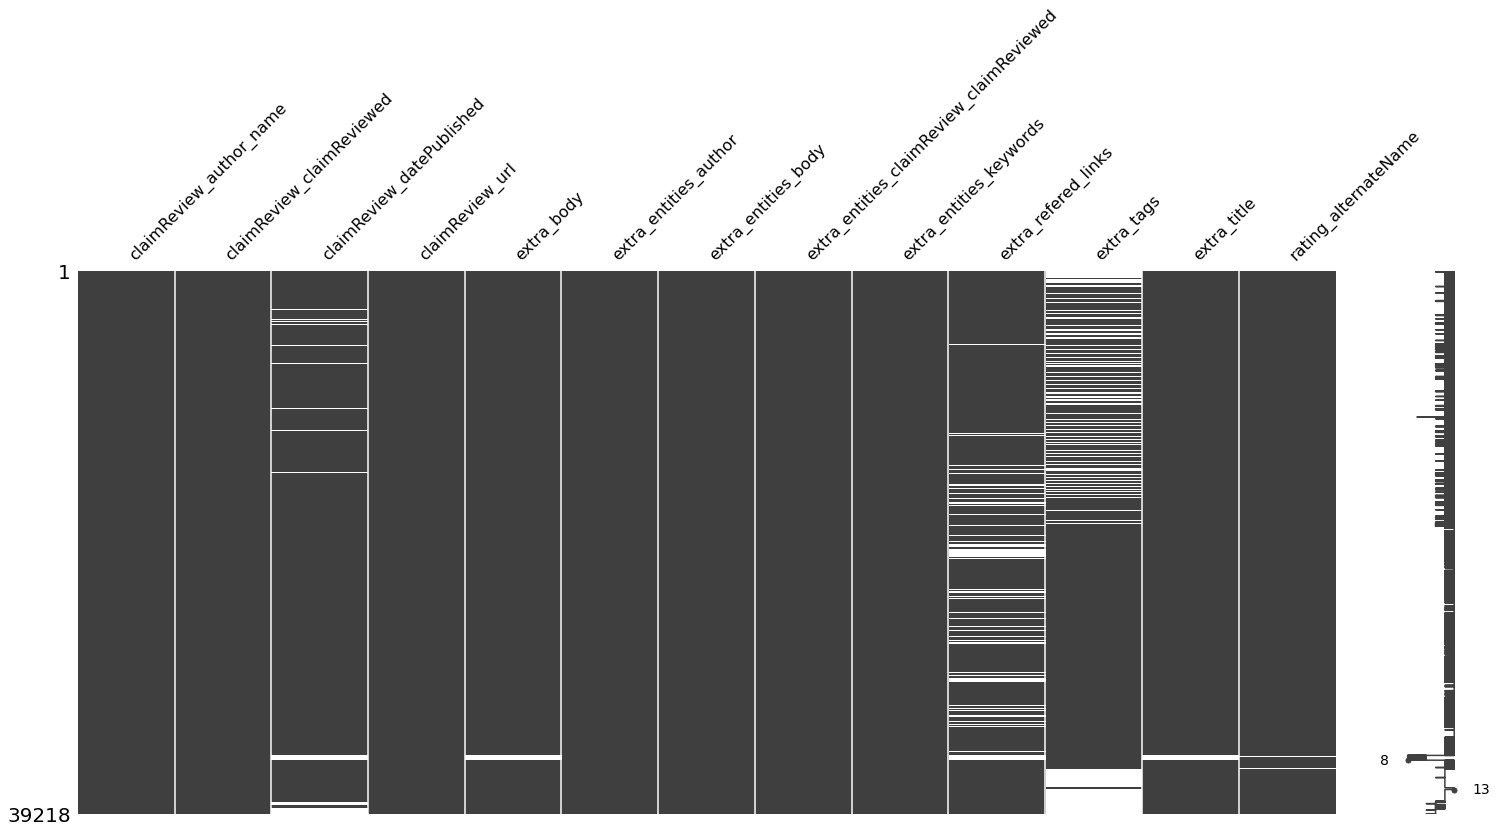

In [7]:
kg.drop(columns=col_manq, inplace=True)
msno.matrix(kg)

## Doublons

In [35]:
duplicateRows = kg[kg.duplicated()]

print("Nombre de lignes redondantes :", len(duplicateRows))

Nombre de lignes redondantes : 0


On voit ici qu'il y a un certain nombre de lignes redondantes.
Il faut alors les supprimer parcequ'elles risquent d'apporter une certaine imprécision.

In [36]:
d = [i for i, v in kg.duplicated().items() if v]
kg.drop(d,inplace=True)

## Autres erreurs dans les données

En parcourant les données, on a remarqué quelques incohérences dans les données qu'on préfère éliminer dès maintenant.

Notamment, certaines lignes contiennent comme claim `true` ou `false`

In [71]:
mask = kg['claimReview_claimReviewed'].isin(["false","true"])
display(kg[mask]['claimReview_claimReviewed'])
rm = set(kg[mask].index.values)

8212     false
11863    false
12054     true
Name: claimReview_claimReviewed, dtype: object

D'autres lignes contiennent rien comme claim. Sans claim, on ne pourra rien faire.

In [72]:
mask = kg['claimReview_claimReviewed'].isnull()
display(kg[mask]['claimReview_claimReviewed'])
rm = rm.union(set(kg[mask].index.values))

38909    NaN
39178    NaN
Name: claimReview_claimReviewed, dtype: object

In [73]:
kg.drop(rm,inplace=True)
print("Nombre d'assertion:",len(kg))

Nombre d'assertion: 33464


## Visualisation des données

### claimReview_author_name

Cet attribut contient le nom de la source de l'assertion.

<AxesSubplot:title={'center':'Valeurs de author_name'}>

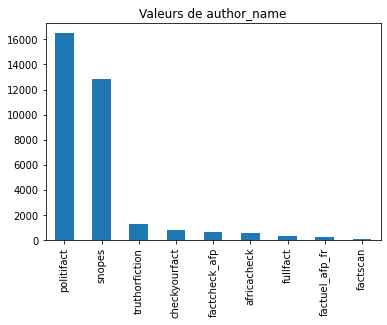

In [74]:
kg['claimReview_author_name'].value_counts().plot(kind='bar',title="Valeurs de author_name")

On voit sur ce graphe que la majorité des assertions viennent de `politifact` et `snopes`.

### claimReview_claimReviewed

Cet attribut contient l'assertion en question.

In [77]:
s = kg[['claimReview_claimReviewed']].sample(5)
display(s)

,claimReview_claimReviewed
38920,Governor Abdullahi Ganduje re-elected in Niger...
29251,"Says it’s a """"statistical reality that most si..."
28583,"""""One person, Kathleen Sebelius, was going to ..."
14836,The athletic shoe company Adidas gained its na...
9383,A billboard in Finland states that it is legal...


NB: Certaine assertions venant de `factuel_afp_fr` et `factcheck_afp` sont en français. Il faut surtout pas les mélanger avec les autres.

Note à plus tard: Trouvez un moyen de séparer proprement les assertions selon leurs langues.

In [79]:
fr_author = ['factcheck_afp', 'factuel_afp_fr']
fr = kg[kg['claimReview_author_name'].isin(fr_author)][['claimReview_claimReviewed']]
print("Nombre d'assertion de",fr_author," : ",len(fr))
display(fr.sample(5))

Nombre d'assertion de ['factcheck_afp', 'factuel_afp_fr']  :  942


,claimReview_claimReviewed
38695,Photo of ‘the first Muslim major general in th...
38912,Billboard encouraging murder in South Africa f...
38530,Une vidéo montre un réfugié qui frappe deux in...
39004,Photos warn of theft at Philippine campaign event
38349,Huit fleuves d’Asie et deux fleuves d’Afrique ...


### claimReview_datePublished

Cet attribut contient la date de publication de l'assertion.

In [82]:
display(kg[['claimReview_datePublished']].sample(3))
print("Nombre de date manquantes:", len(kg[kg['claimReview_datePublished'].isnull()]))

,claimReview_datePublished
33714,2016-11-29
38016,2018-05-14
36054,2019-09-10


Nombre de date manquantes: 1301


### claimReview_url

Lien vers l'article qui parle de cette assertion

In [85]:
display(kg[['claimReview_url']].sample(3))
print("Nombre de liens manquants:",len(kg[kg['claimReview_url'].isnull()]))

,claimReview_url
22762,http://www.politifact.com/rhode-island/stateme...
28657,http://www.politifact.com/wisconsin/statements...
5366,https://www.snopes.com/fact-check/cheating-hus...


Nombre de liens manquants: 0


## Premier traitement sur les données

On a vu que certaines données ne seront pas utilisable pour l'entraînement du modèle. Voici donc une fonction qui prend en paramètre le dataframe et supprimes toutes les colonnes et lignes à supprimer avant de commencer le prétraitement.

In [89]:
def clean_claimKG(df, verbose=False, inplace=False):
    if verbose:
        print("Taille du dataframe:",df.shape)
    nb_assertion = len(df)
    manq = df.isnull().sum()
    col_manq = ['Unnamed: 0','claimReview_source']
    for k, v in manq.items():
        if v > nb_assertion/2 :
            col_manq.append(k)
    if verbose:
        print("Suppression des columns suivant:",col_manq)
    df = df.drop(columns=col_manq,inplace=inplace)

    d = [i for i, v in df.duplicated().items() if v]
    if verbose:
        print("Suppression de",len(d),"lignes en doubles.")
    df = df.drop(d,inplace=inplace)
    
    mask = df['claimReview_claimReviewed'].isin(["false","true"])
    rm = set(df[mask].index.values)
    mask = df['claimReview_claimReviewed'].isnull()
    rm = rm.union(set(df[mask].index.values))
    
    if verbose:
        print("Suppression de",len(rm),"lignes.")
    df = df.drop(rm, inplace=inplace)

    if verbose:
        print("Taille finale:",df.shape)
    return df

kg_test = clean_claimKG(origin,verbose=True)

Taille du dataframe: (39218, 23)
Suppression des columns suivant: ['Unnamed: 0', 'claimReview_source', 'claimReview_author', 'claimReview_author_url', 'creativeWork_author_name', 'creativeWork_author_sameAs', 'creativeWork_datePublished', 'rating_bestRating', 'rating_ratingValue', 'rating_worstRating']
Suppression de 5749 lignes en doubles.
Suppression de 5 lignes.
Taille finale: (33464, 13)


Ce code est disponible sous [clean.py]("./clean.py") pour réutilisation plus tard.

La prochaine étape est le prétraitement (tokenisation, lemmatisation, ...). On se retrouve sur le notebook [pretraitement.ipynb]("./pretraitement.ipynb").